In [1]:
import pandas as pd
import numpy as np
import stan
from datetime import datetime
from scipy.interpolate import BSpline
from scipy.stats import t
import arviz as az

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import nest_asyncio
nest_asyncio.apply()

In [2]:
# function to determine the season based on the month
def get_season(month):
    if month in ["03", "04", "05"]:
        return 1
    elif month in ["06", "07", "08"]:
        return 2
    elif month in ["09", "10", "11"]:
        return 3
    else:
        return 0

# function to calculate Mother's Day for a given year
def calculate_mothers_day(year):
    first_sunday = pd.Timestamp(f'{year}-05-01').to_pydatetime()
    while first_sunday.weekday() != 6:
        first_sunday += pd.Timedelta(days=1)
    
    second_sunday = first_sunday + pd.Timedelta(days=7)
    
    return second_sunday.strftime("%m/%d/%y")

In [3]:
df = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv')

# filter for gun violence incidents
df = df[(df.Description == 'SHOOTING')+((df.Description == 'HOMICIDE')*(df.Weapon == 'FIREARM'))]

# aggregate by date
df = df.groupby('CrimeDate').size().reset_index(name='shootings')
df['CrimeDate'] = pd.to_datetime(df.CrimeDate).dt.strftime("%m/%d/%y")

# fill missing dates with zeros
full_date_range = pd.date_range(start=df['CrimeDate'].min(), end=df['CrimeDate'].max(), freq='D').strftime("%m/%d/%y")
df = pd.merge(pd.DataFrame({'CrimeDate': full_date_range}), df, on='CrimeDate',how='left')
df = df.fillna(0)

/tmp/ipykernel_319171/2473970885.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CrimeDate'] = pd.to_datetime(df.CrimeDate).dt.strftime("%m/%d/%y")


In [4]:
# define ceasefire weekends
ceasefire_fridays = [
"08/04/2017",
"11/03/2017",
"02/02/2018",
"05/11/2018",
"08/03/2018",
"11/02/2018",
"02/01/2019",
"05/10/2019",
"08/02/2019"
]

ceasefire_fridays = [datetime.strptime(date_str, "%m/%d/%Y") for date_str in ceasefire_fridays]

# generate the ceasefire weekends
ceasefire_weekends = [pd.date_range(start=friday, periods=3, freq='D') for friday in ceasefire_fridays]
ceasefire_weekends = [date.strftime("%m/%d/%y") for sublist in ceasefire_weekends for date in sublist]

# set binary indicators for ceasefire and related weekends
df['ceasefire'] = df['CrimeDate'].isin(ceasefire_weekends)
df['three_after'] = np.roll(df.ceasefire,3)
df['weekend_after'] = np.roll(df.ceasefire,7)


In [5]:
# define Mother's Day for each year
mothers_days = []
for year in pd.to_datetime(df['CrimeDate']).dt.year.unique():
    mothers_days.append(calculate_mothers_day(year))

df['mothersday'] = df['CrimeDate'].isin(mothers_days)

/tmp/ipykernel_319171/2651990021.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  for year in pd.to_datetime(df['CrimeDate']).dt.year.unique():


In [6]:
# encode relevant date information
day_to_num = {'Sunday': 0, 'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6}
df.loc[:,'weekday'] = [day_to_num[x] for x in pd.to_datetime(df.CrimeDate).dt.day_name()]
df.loc[:,'yearday'] = pd.to_datetime(df.CrimeDate).dt.dayofyear
df.loc[:,'season'] = [get_season(c.split("/")[0]) for c in df.CrimeDate]
df.loc[:,'jul'] = pd.to_datetime(df.CrimeDate).apply(lambda x: x.toordinal())

/tmp/ipykernel_319171/1594257623.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.loc[:,'weekday'] = [day_to_num[x] for x in pd.to_datetime(df.CrimeDate).dt.day_name()]
/tmp/ipykernel_319171/1594257623.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.loc[:,'yearday'] = pd.to_datetime(df.CrimeDate).dt.dayofyear
/tmp/ipykernel_319171/1594257623.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.loc[:,'jul'] = pd.to_datetime(df.CrimeDate).apply(lambda x: x.toordinal())


We're going to predict shootings using the following covariates:

* Overall time trend
    + We use a spline to estimate the overall time trend, which allows for "curvy" relationships while avoiding overfitting
    
* Yearly seasonality
    + We account for yearly seasonality using a spline with a cyclical constraint to ensure that the seasonal effect begins where it ended
    
* Day of the week
    + We allow intercepts to vary for days of the week in case weekends have different patterns of shootings than weekdays
    
* Calendar day
    + We allow varying intercepts for each day of the year in case "special days", like Christmas, show different patterns of shootings 
    
* Mother's Day
    + We use a binary indicator for Mother's Day, which is the second Sunday in May and always coincides with ceasefire
    
* Ceasefire effect
    + We use a binary indicator for days occurring during ceasefire weekends to estimate the impact of ceasefire after accounting for all of the above

/tmp/ipykernel_319171/3766049952.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['2012','2013','2014','2015','2016','2017','2018','2019'])


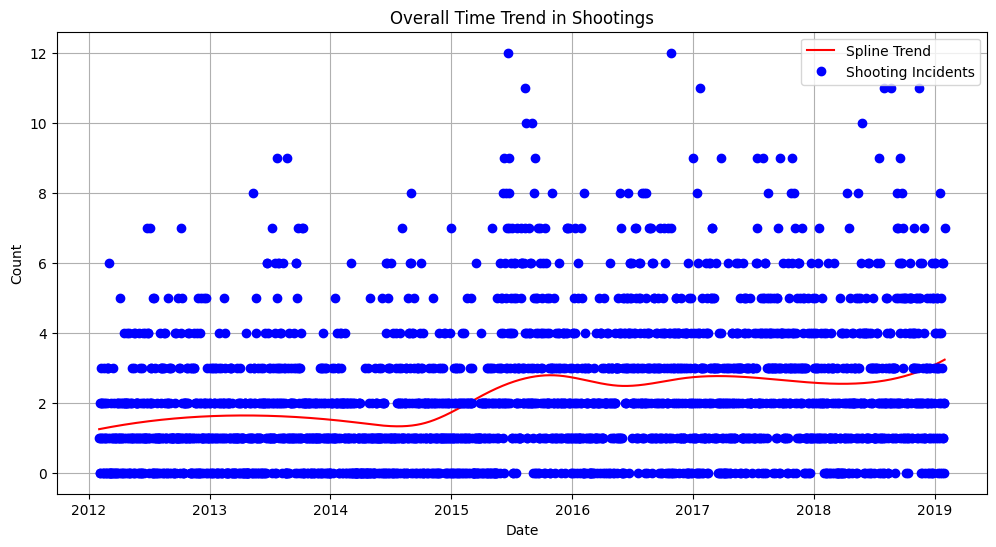

In [7]:
# fit spline for overall time trend
knots = np.linspace(df.jul.min(), df.jul.max(), 14)
degree = 3
spline_basis = BSpline(knots, np.eye(len(knots)), degree)
spline_coefficients = np.linalg.lstsq(spline_basis(df.jul), df.shootings, rcond=None)[0]
eval = df.jul
overall_spline = np.dot(spline_basis(eval), spline_coefficients)

# plot overall time trend
plt.figure(figsize=(12, 6))
plt.plot(df.CrimeDate, overall_spline, 'r-', label='Spline Trend')
plt.plot(df.CrimeDate, df.shootings, 'bo', label='Shooting Incidents')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Overall Time Trend in Shootings')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(month=12))
plt.gca().set_xticklabels(['2012','2013','2014','2015','2016','2017','2018','2019'])
plt.grid(True)
plt.show()

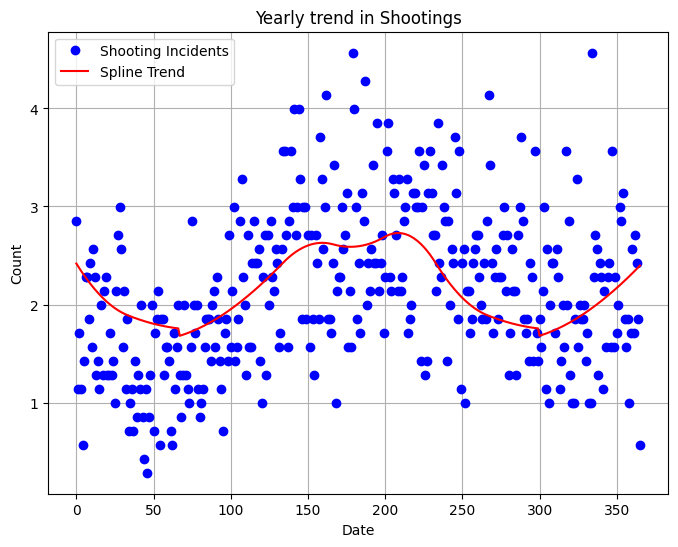

In [8]:
# fit spline for yearly trend
year_counts = np.zeros(366)
for yearday, count in zip(df.yearday, df.shootings):
    year_counts[yearday-1] += count    
year_counts = year_counts/(len(df)/365)

knots = np.linspace(0, 366, 12)
degree = 2
spline_basis = BSpline(knots, np.eye(len(knots)), degree, extrapolate='periodic')

spline_coefficients = np.linalg.lstsq(spline_basis(np.arange(366)), year_counts, rcond=None)[0]

eval = np.arange(0, 366)
year_spline = np.dot(spline_basis(eval), spline_coefficients)

# plot yearly trend
plt.figure(figsize=(8, 6))
plt.plot(np.arange(366), year_counts, 'bo', label='Shooting Incidents')
plt.plot(eval, year_spline, 'r-', label='Spline Trend')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Yearly trend in Shootings')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
N = len(df)

# prepare data for Stan model
data = {
    'n': N,
    'y': df['shootings'].values.astype(int),
    'overall': (df['jul']-df['jul'][0]).values.astype(int)+1,
    'ceasefire': df['ceasefire'].values.astype(int)+1,
    'residual': df['three_after'].values.astype(int)+1,
    'residual_weekend': df['weekend_after'].values.astype(int)+1,
    'mothersday': df['mothersday'].values.astype(int)+1,
    'yday': df['yearday'].values.astype(int),
    'weekday': df['weekday'].values.astype(int)+1,
    'season': df['season'].values.astype(int)+1,
    'y_overall': overall_spline,
    'y_year': year_spline
}

In [12]:
stan_code = """
data {
    int<lower=1> n;                   // Number of observations
    array[n] int y;               // Number of shootings per day
    array[n] int overall;         //overall time period
    array[n] int ceasefire;
    array[n] int residual;
    array[n] int residual_weekend;
    array[n] int mothersday;
    array[n] int yday;
    array[n] int weekday;
    array[n] int season;
    
    vector[n] y_overall;                //overall spline
    vector[366] y_year;                 //yearly spline
    
}

parameters {
    vector[n] mu_innovations;
    vector[7] weekday_effects;
    vector[2] ceasefire_effects;
    vector[2] residual_effects;
    vector[2] residual_weekend_effects;
    vector[2] mothersday_effects;
    vector[4] season_effects;
    
    real<lower=0> sigma_mu;
    real<lower=0> sigma_weekday;
    real<lower=0> sigma_binary;
    real<lower=0> sigma_seasonal;
    real baseline;
    }

transformed parameters {
    vector[7] y_week;
    vector[2] y_cease;
    vector[2] y_resid;
    vector[2] y_resid_weekend;
    vector[2] y_mother;
    vector[4] y_seasonal;
    vector[n] mu;
    {
        vector[7] week_with_trend;
        real trend;
        week_with_trend = cumulative_sum(weekday_effects);
        trend = week_with_trend[7];
        for (i in 1:7)
            y_week[i] = sigma_weekday/100 * (week_with_trend[i] - trend * i/7);
    }
    {
        vector[2] cease_with_trend;
        vector[2] mother_with_trend;
        vector[2] resid_with_trend;
        vector[2] resid_weekend_trend;
        real cease_trend;
        real mother_trend;
        real resid_trend;
        real resid_weekend;
        cease_with_trend = cumulative_sum(ceasefire_effects);
        mother_with_trend = cumulative_sum(mothersday_effects);
        resid_with_trend = cumulative_sum(residual_effects);
        resid_weekend_trend = cumulative_sum(residual_weekend_effects);
        cease_trend = cease_with_trend[2];
        mother_trend = mother_with_trend[2];
        resid_trend = resid_with_trend[2];
        resid_weekend = resid_weekend_trend[2];
        for (i in 1:2) {
            y_cease[i] = sigma_binary/100 * (cease_with_trend[i] - cease_trend * i/2);
            y_mother[i] = sigma_binary/100 * (mother_with_trend[i] - mother_trend * i/2);
            y_resid[i] = sigma_binary/100 * (resid_with_trend[i] - resid_trend * i/2);
            y_resid_weekend[i] = sigma_binary/100 * (resid_weekend_trend[i] - resid_weekend * i/2);
        }
    }
    {
        vector[4] season_with_trend;
        real trend;
        season_with_trend = cumulative_sum(season_effects);
        trend = season_with_trend[4];
        for (i in 1:4)
            y_seasonal[i] = sigma_seasonal/100 * (season_with_trend[i] - trend * i/4);
    }
    mu = sigma_mu/100 * cumulative_sum(mu_innovations);
}

model {
    weekday_effects ~ normal(0,1);
    ceasefire_effects ~ normal(0,1);
    residual_effects ~ normal(0,1);
    residual_weekend_effects ~ normal(0,1);
    mothersday_effects ~ normal(0,1);
    season_effects ~ normal(0,1);
    mu_innovations ~ normal(0, 1);
    y ~ poisson_log(baseline + mu + y_year[yday] + (y_overall[overall]) + y_week[weekday] + y_cease[ceasefire] + y_resid[residual] + y_resid_weekend[residual_weekend] + y_mother[mothersday] + y_seasonal[season]);
    sigma_mu ~ lognormal(-3.5 + log(100), 2);
    sigma_weekday ~ lognormal(-3.5 + log(100), 2);
    sigma_binary ~ lognormal(-3.5 + log(100), 2);
    sigma_seasonal ~ lognormal(-3.5 + log(100), 2);
}

generated quantities {
    vector[n] lin_pred;    // Linear predictor
    vector[n] lower_bound;
    vector[n] upper_bound;

    lin_pred = baseline + mu + y_year[yday] + (y_overall[overall]) + y_week[weekday] + y_cease[ceasefire] + y_resid[residual] + y_resid_weekend[residual_weekend] + y_mother[mothersday] + y_seasonal[season];
    
}

"""

In [13]:
# build and sample the model
model = stan.build(stan_code, data=data)
fit = model.sample(num_chains=4, num_samples=500, num_warmup=500)

Building...


Building: 109.8s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Connection reset by peer [system:104]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/vianie/anaconda3/envs/cogmod/lib/python3.11/concurrent/futures/process.py", line 261, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: write: Connection reset by peer

In [49]:
# summary and trace plot
print(az.summary(fit))
_ = az.plot_trace(fit)

corrs = az.autocorr(fit['mu_innovations'])

corrs = corrs.reshape(corrs.shape[0],500,4)
for i in range(4):
    for samp in range(corrs.shape[0]):
        plt.plot(corrs[samp,:, i])
    plt.title(f'Chain {i+1}')
    plt.show()


/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/vianie/anaconda3/envs/cogmod/lib/p

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_innovations[0] -0.024  1.040  -1.928    1.918      0.019    0.027   
mu_innovations[1]  0.000  1.005  -1.846    1.863      0.020    0.026   
mu_innovations[2]  0.105  0.968  -1.649    1.860      0.016    0.023   
mu_innovations[3]  0.072  0.996  -1.794    1.905      0.015    0.027   
mu_innovations[4]  0.176  1.003  -1.869    1.894      0.019    0.024   
...                  ...    ...     ...      ...        ...      ...   
upper_bound[2553]  5.652  0.716   4.355    6.981      0.039    0.028   
upper_bound[2554]  5.786  0.721   4.415    7.043      0.040    0.028   
upper_bound[2555]  5.814  0.723   4.495    7.154      0.039    0.028   
upper_bound[2556]  5.851  0.727   4.482    7.138      0.039    0.028   
interval_width     9.044  1.452   6.397   11.720      0.082    0.058   

                   ess_bulk  ess_tail  r_hat  
mu_innovations[0]    2842.0    1415.0   1.00  
mu_innovations[1]    2511.0    1141.0   1

/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(


: 

In [46]:
results = fit.to_frame()
convergence = az.summary(fit)

/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/vianie/anaconda3/envs/cogmod/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/vianie/anaconda3/envs/cogmod/lib/p

In [47]:
convergence

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_innovations[0],-0.024,1.040,-1.928,1.918,0.019,0.027,2842.0,1415.0,1.00
mu_innovations[1],0.000,1.005,-1.846,1.863,0.020,0.026,2511.0,1141.0,1.01
mu_innovations[2],0.105,0.968,-1.649,1.860,0.016,0.023,3740.0,1589.0,1.00
mu_innovations[3],0.072,0.996,-1.794,1.905,0.015,0.027,4515.0,1450.0,1.01
mu_innovations[4],0.176,1.003,-1.869,1.894,0.019,0.024,2894.0,1540.0,1.00
...,...,...,...,...,...,...,...,...,...
upper_bound[2553],5.652,0.716,4.355,6.981,0.039,0.028,329.0,777.0,1.01
upper_bound[2554],5.786,0.721,4.415,7.043,0.040,0.028,326.0,589.0,1.01
upper_bound[2555],5.814,0.723,4.495,7.154,0.039,0.028,330.0,722.0,1.01
upper_bound[2556],5.851,0.727,4.482,7.138,0.039,0.028,336.0,667.0,1.01


/tmp/ipykernel_319171/994682213.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['2012','2013','2014','2015','2016','2017','2018','2019'])


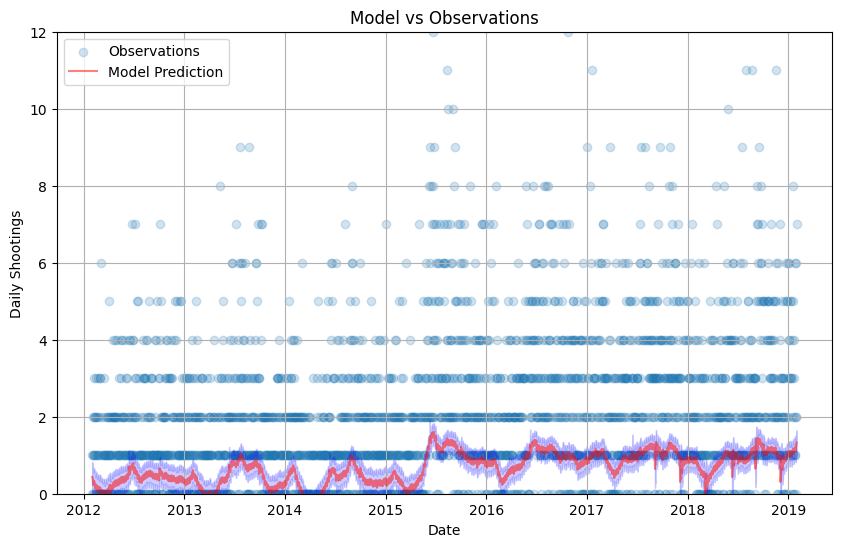

In [48]:
# plot model vs observations
plt.figure(figsize=(10, 6))
plt.scatter(df['CrimeDate'], df['shootings'], alpha=0.2, label='Observations')
plt.plot(df['CrimeDate'], np.mean(fit['lin_pred'], axis=1), color='red', alpha=0.5, label='Model Prediction')
plt.fill_between(df['CrimeDate'], convergence.loc['lin_pred[0]':'lin_pred[2556]','hdi_3%'], convergence.loc['lin_pred[0]':'lin_pred[2556]','hdi_97%'], color='blue', alpha=0.2)
plt.ylim(0,12)
plt.xlabel('Date')
plt.ylabel('Daily Shootings')
plt.title('Model vs Observations')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator(month=12))
plt.gca().set_xticklabels(['2012','2013','2014','2015','2016','2017','2018','2019'])
plt.grid(True)
plt.show()

In [ ]:
# plot weekday effects
plt.figure(figsize=(10, 6))
plt.boxplot(fit.to_frame().loc[:,["weekday_effects.2","weekday_effects.3","weekday_effects.4","weekday_effects.5","weekday_effects.6","weekday_effects.7","weekday_effects.1"]])
plt.gca().set_xticklabels(['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylabel('Daily Shootings')
plt.title('Weekday effects')
plt.show()

In [ ]:
# calculate and display credible interval for Mother's Days
mother_effect_samples = results["mothersday_effects.2"]
point_estimate = np.mean(mother_effect_samples)
credible_interval = np.percentile(mother_effect_samples, [2.5, 97.5])

print("Point Estimate for Shootings on Mothers' day:", point_estimate)
print("95% Credible Interval:", credible_interval)

In [ ]:
# calculate and display credible interval for ceasfire weekends
ceasefire_effect_samples = results["ceasefire_effects.2"]
point_estimate = np.mean(ceasefire_effect_samples)
credible_interval = np.percentile(ceasefire_effect_samples, [2.5, 97.5])

print("Point Estimate for Shootings on Ceasefire Days:", point_estimate)
print("95% Credible Interval:", credible_interval)

In [ ]:
# calculate and display credible interval for the days following the ceasefire weekends
resid_effect_samples = results["residual_effects.2"]
point_estimate = np.mean(resid_effect_samples)
credible_interval = np.percentile(resid_effect_samples, [2.5, 97.5])

print("Point Estimate for Shootings on following days:", point_estimate)
print("95% Credible Interval:", credible_interval)

In [ ]:
# calculate and display credible interval for weekend after ceasfire weekends
next_effect_samples = results["residual_weekend_effects.2"]
point_estimate = np.mean(next_effect_samples)
credible_interval = np.percentile(next_effect_samples, [2.5, 97.5])

print("Point Estimate for Shootings on following weekends:", point_estimate)
print("95% Credible Interval:", credible_interval)